Srinivasan Venkataraman <br>
mv.srinivasan@gmail.com <br>
Predict the time to erupt and the magnitude of eruption of the volcanoes

In [1]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 3.7 MB/s eta 0:00:00


In [2]:
import random
import math
from pathlib import Path
import re
import itertools
import warnings

import numpy as np
import pandas as pd
from google.colab import drive

# Libraries for Prep/Feature Engineering
from tsfresh import extract_features
from tsfresh import feature_extraction
from tsfresh import extract_relevant_features
from tsfresh import feature_extraction

import sklearn.datasets as  datasets
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

# Libraries for Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

#Libraries for Modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

#Libraries for Measuring Model accuracy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")
extract_features.show_warnings=False


boxcox = PowerTransformer(method = 'box-cox', standardize = True)

dic_results = {}


drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
def boxcox_transformer(tilt_erupt_values):
  min_value = min(tilt_erupt_values)
  if min_value < 0:
    tilt_erupt_values = np.array([2 * abs(min_value) + x for x in tilt_erupt_values])
  tilt_erupt_values = boxcox.fit_transform(tilt_erupt_values.reshape(-1,1))
  return tilt_erupt_values[:, 0]


In [4]:
def default_transform(tilt_erupt_values):
  return tilt_erupt_values

In [5]:
def get_observations_from_file(filename, transformer):
  TIMESERIES_LINE = 14
  TILT_VALUES_LINE = 15
  with open(filename,'r') as f:
    lines = f.readlines()
  timeseries_line = lines[TIMESERIES_LINE]
  tilt_erupt_values_line = lines[TILT_VALUES_LINE]
  timeseries = [int(x) for x in timeseries_line.split(',')]
  tilt_erupt_values = [float(x) for x in tilt_erupt_values_line.split(',')]
  return np.column_stack((timeseries, transformer(tilt_erupt_values)))


In [6]:
pathlist = Path('.').rglob("observation*.txt")
filelist = list(pathlist)
total_files = len(filelist)
df_series = [ pd.DataFrame({'time': [] , 'id':[], 'x': []})] * total_files # each entry in the list corresponds to one observation file
X_train_index, X_test_index = train_test_split(np.arange(total_files), train_size = 0.75, random_state = 0)
obs = np.array([])

for i, path in enumerate(filelist):
  path_in_str = str(path)
  obs = get_observations_from_file(path_in_str, boxcox_transformer) # transformer=default_transform
  df_series[i] = pd.DataFrame({'time': obs[:, 0], 'id':1, 'x': obs[:, 1]})
  df_series[i].drop_duplicates(subset=['time'], keep='first', inplace=True)
  df_series[i].dropna()





Let us randomly pick 5 series and plot their curve

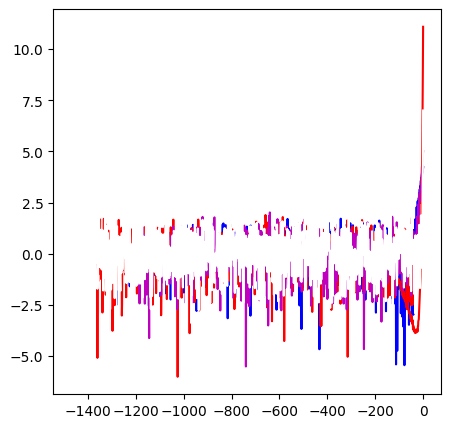

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
for i in np.random.randint(0, total_files, size=5):
  ax.plot(df_series[i]['time'], df_series[i]['x'], c=random.choice(list(mcolors.BASE_COLORS.keys())))

# Trying a heuristical model of feature engineering<br>
We generate randomly picked subsequences of  length 100,200,300,400 <br>Generate the features with pressure value start , pressure value end, mean, length of segment, min_value, max_value, standard deviation


In [8]:
def get_featured_row_from_reading(df:pd.DataFrame, id:int, start:int, end:int):   # Try our version of extracting some features for regression
  time_series = np.array([int(x) for x in df.iloc[start:end]['time']])
  sub_seq = np.array([float(x) for x in df.iloc[start:end]['x']])
  feature = {
    'tilt_begin' : sub_seq[0],
    'tilt_end' : sub_seq[-1],
    'seq_len' : len(sub_seq),
    'min': np.min(sub_seq),
    'max': np.max(sub_seq),
    'mean': np.mean(sub_seq),
    'median': np.median(sub_seq),
    'std' : np.std(sub_seq)
  }
  #print(feature)
  y1 =  int(df.iloc[start+len(sub_seq)-1, 0]) # we could not use end, as actual extraction could be less then end-start+1
  y2 = df.iloc[-1, 2] # final tilt value
  return pd.DataFrame([feature]), y1, y2

In [9]:
def get_timeseries_row_from_reading(df:pd.DataFrame, id, start:int, end:int):
  sub_seq = df[start:end]['x']
  time_series = pd.DataFrame({'tilt_value': np.array(sub_seq), 'id':id, 'time': [i for i in range(len(sub_seq))]}, index = [i for i in range(len(sub_seq))])
  # remove time to erupt  from training and sythetically increase time
  end =  min(end, len(df))
  y_time_to_erupt = -df.iloc[end-1]['time'] if df.iloc[end-1]['time'] < 0 else 0
  y_tilt_value = df.iloc[-1]['x']
  return time_series, y_time_to_erupt, y_tilt_value


In [10]:
def curate_input(df:pd.DataFrame):
  df.dropna(axis=1, inplace=True)
  keep_indices = np.array(np.isfinite(df).all(1))
  return df[keep_indices], keep_indices


In [11]:
def build_dataset(iterations:int, index_set:list[int], tsfresh=False):
  seq_length = [50, 100, 200, 400]
  seq_vals = [[]] * iterations * len(seq_length)
  yt = [0] * len(seq_vals)  #initialize y_train for time to erupt
  ym = [0.0] * len(seq_vals) #initialize y_train for magnitude
  t = 0
  for _ in range(iterations):
    i = random.choice(index_set) # choose an observation randomly from the set
    j = np.random.randint(0, len(df_series[i])) # choose a random time value to start with
    for s in seq_length: # take samples of length
      if tsfresh == False :
        seq_vals[t], yt[t], ym[t] = get_featured_row_from_reading(df_series[i], id=t, start=j, end=j+s)
      else:
        seq_vals[t], yt[t], ym[t] = get_timeseries_row_from_reading(df_series[i], id=t, start=j, end=j+s)
      t += 1

  if tsfresh == False:
    return pd.concat(seq_vals), yt, ym
  else:
    all_values = pd.concat(seq_vals)
    df = pd.DataFrame(all_values)
    features =  extract_features(df, column_id="id", column_sort="time", disable_progressbar=True, show_warnings=False, n_jobs=4)
    return features, yt, ym


In [12]:
def prepare_dataset(tsfresh=False, iterations=1000):
  X_train, yt_train, ym_train = build_dataset(iterations, X_train_index, tsfresh)
  X_train, keep_indices = curate_input(X_train)
  yt_train = np.array([yt_train[i] for i,x in enumerate(keep_indices) if keep_indices[i]])
  ym_train = np.array([ym_train[i] for i,x in enumerate(keep_indices) if keep_indices[i]])

  X_test, yt_test, ym_test = build_dataset(iterations // 4, X_test_index, tsfresh)
  X_test, keep_indices = curate_input(X_test)
  yt_test = np.array([yt_test[i] for i,x in enumerate(keep_indices) if keep_indices[i]])
  ym_test = np.array([ym_test[i] for i,x in enumerate(keep_indices) if keep_indices[i]])

  col_test = set(X_test.columns)
  col_train = set(X_train.columns)
  X_test.drop(col_test-col_train, axis=1, inplace=True)
  X_train.drop(col_train-col_test, axis=1, inplace=True)
  return X_train, X_test, yt_train, yt_test, ym_train, ym_test

In [13]:
def report_accuracy(y_test, y_pred, label):
  r2 = r2_score(y_test, y_pred)
  mse = mean_squared_error(yt_test, yt_pred)
  dic_results[label] = { 'r2' : r2, 'mse' : mse }
  print(f'{label} : r2={r2}, mean_squared_error={mse}')
  plt.plot([x for x,y in enumerate(y_test[:50])], y_test[:50], c='blue', label='Actual', linewidth=1, linestyle='solid')
  plt.plot([x for x,y in enumerate(y_test[:50])], y_pred[:50], c='red', label='Predicted', linewidth=1, linestyle='dashed')
  plt.legend(loc="upper left")
  plt.grid(True)
  plt.title(f'{label}: Predicted  vs actual - first 50 observations')
  plt.show()

LinearRegression-Naive:Time To Erupt : r2=0.20830137558337747, mean_squared_error=101988.53751442274


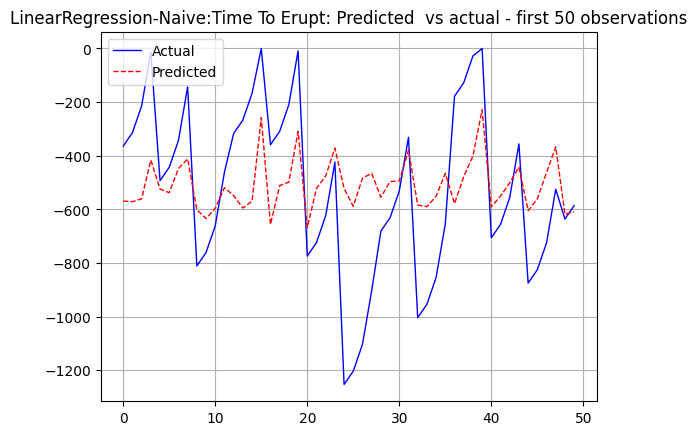

LinearRegression-Naive:Amplitude : r2=0.27337336307744353, mean_squared_error=101988.53751442274


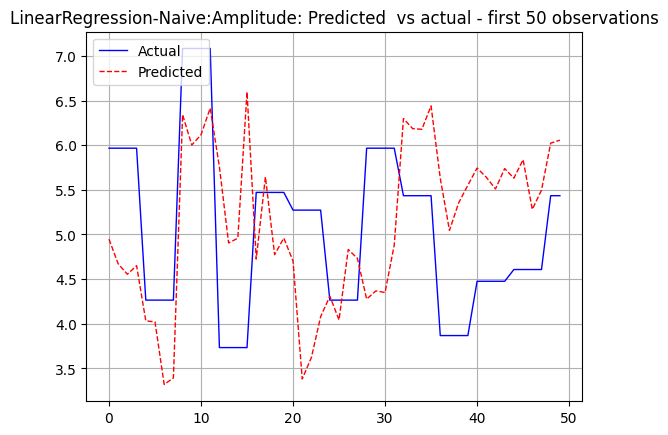

In [13]:
#Try Linear Regression with heuristically engineered Features
X_train, X_test, yt_train, yt_test, ym_train, ym_test = prepare_dataset(tsfresh=False, iterations=1000)
model = LinearRegression()
model.fit(X_train, yt_train)
yt_pred = model.predict(X_test)
report_accuracy(yt_test, yt_pred, 'LinearRegression-Naive:Time To Erupt')
model.fit(X_train, ym_train)
ym_pred = model.predict(X_test)
report_accuracy(ym_test, ym_pred, 'LinearRegression-Naive:Amplitude')



As we can see the $R^{2}$ score is pretty low and mean squared error is high. The actual vs predicted graph clearly shows that. Let us try TSFresh






In [14]:
X_train, X_test, yt_train, yt_test, ym_train, ym_test = prepare_dataset(tsfresh=True, iterations=100)

LinearRegressionTSFresh:Time To Erupt : r2=-1380.0836913609178, mean_squared_error=175031119.97181237


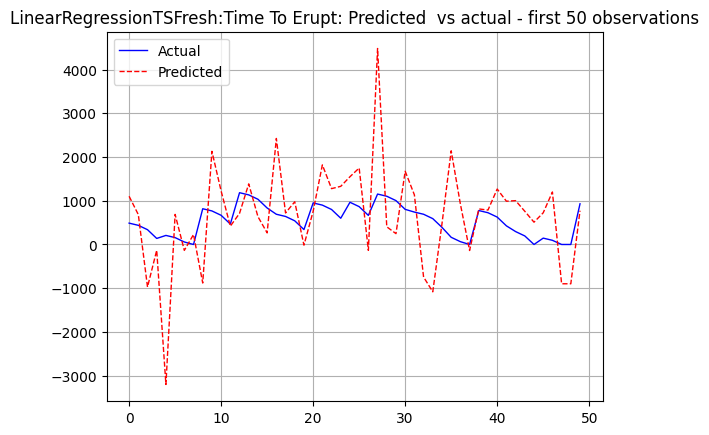

LinearRegression:Amplitude : r2=-30883.71124736207, mean_squared_error=175031119.97181237


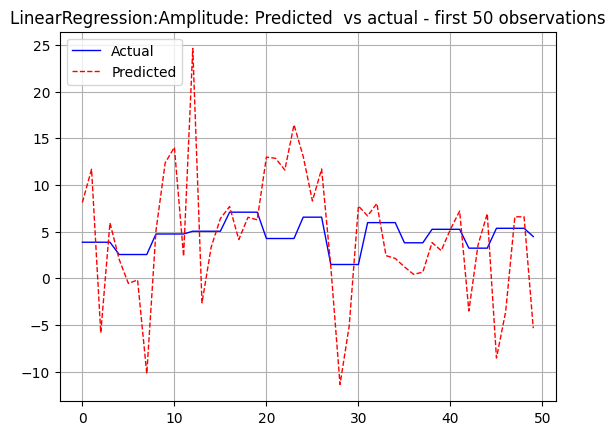

In [15]:
#Try Linear Regression with engineered Features generated from TS Fresh Library
model = LinearRegression()
model.fit(X_train, yt_train)
yt_pred = model.predict(X_test)
report_accuracy(yt_test, yt_pred, 'LinearRegressionTSFresh:Time To Erupt')
model.fit(X_train, ym_train)
ym_pred = model.predict(X_test)
report_accuracy(ym_test, ym_pred, 'LinearRegression:Amplitude')

As we can see the  $𝑅^{2}$  score and MSE are way worse with Linear Regression on features extracted by tsfresh. Though the actual vs predicted graph starting to look aligned with predictions  our training error is still high. Let us try Decision Trees

DecisionTree:Time To Erupt : r2=-0.5336122564419117, mean_squared_error=194361.77005538004


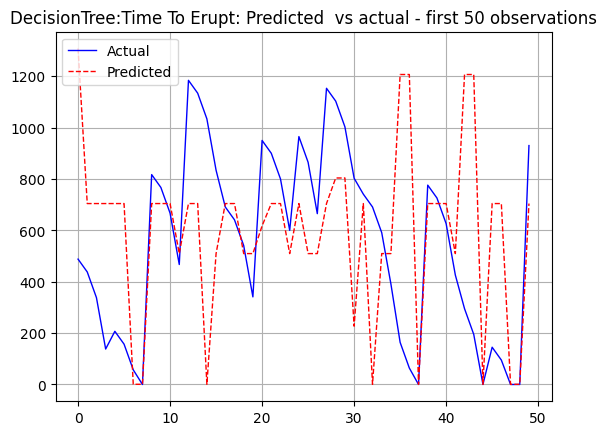

DecisionTree:Amplitude : r2=-0.4369540969997141, mean_squared_error=194361.77005538004


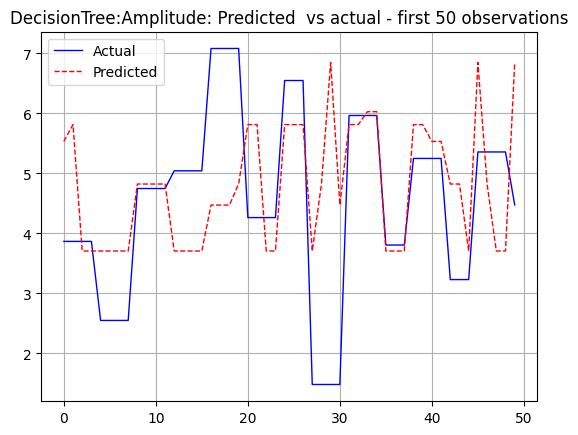

In [16]:
dt_regressor = DecisionTreeRegressor(criterion="squared_error",max_depth=5,random_state=1) # Try playing around with max_depth 3, 5, 8
dt_regressor.fit(X_train, yt_train)
yt_pred = dt_regressor.predict(X_test)
report_accuracy(yt_test, yt_pred, 'DecisionTree:Time To Erupt')
dt_regressor.fit(X_train, ym_train)
ym_pred = dt_regressor.predict(X_test)
report_accuracy(ym_test, ym_pred, 'DecisionTree:Amplitude')

On a DecisionTreeRegressor we can see the  $𝑅^{2}$  score has further improved compared to LinearRegression  and so has the MSE. The actual vs predicted graph is starting to look more aligned with the predictions but we still have some ways to go to clean up the bias.

Let us try Boosting

HistGradientBoost:Time To Erupt : r2=0.15591768168707631, mean_squared_error=106974.45379079919


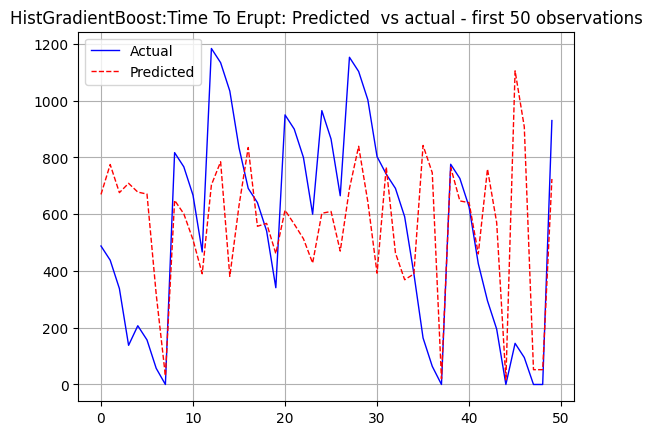

HistGradientBoost:Amplitude : r2=0.2286304653415494, mean_squared_error=106974.45379079919


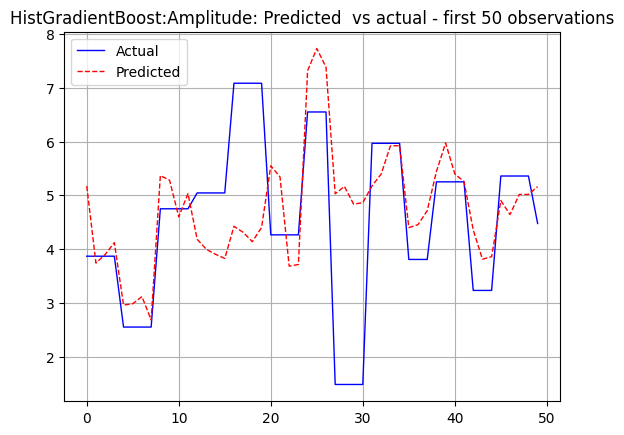

In [17]:
gb_regressor = HistGradientBoostingRegressor()
gb_regressor.fit(X_train, yt_train)
yt_pred = gb_regressor.predict(X_test)
report_accuracy(yt_test, yt_pred, 'HistGradientBoost:Time To Erupt')
gb_regressor.fit(X_train, ym_train)
ym_pred = gb_regressor.predict(X_test)
report_accuracy(ym_test, ym_pred, 'HistGradientBoost:Amplitude')

Let us try RandomForestRegressor. The benefit is after the model is fitted, we could look at the Feature Importance Rankings and see if we can run a model with just the top 5 features

RandomForest:Time To Erupt : r2=0.28998881282533673, mean_squared_error=89982.99962635715


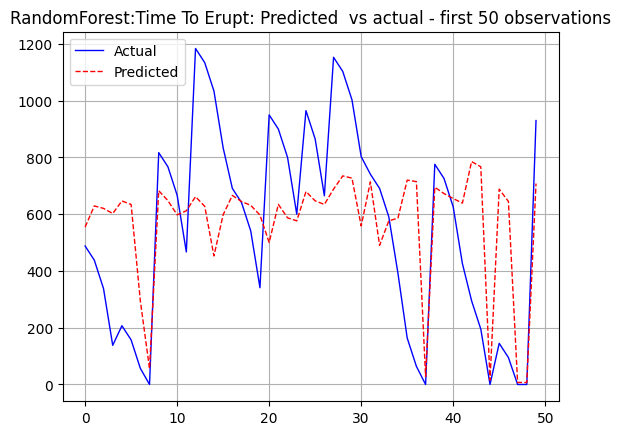

RandomForest:Amplitude : r2=0.08423485512712814, mean_squared_error=89982.99962635715


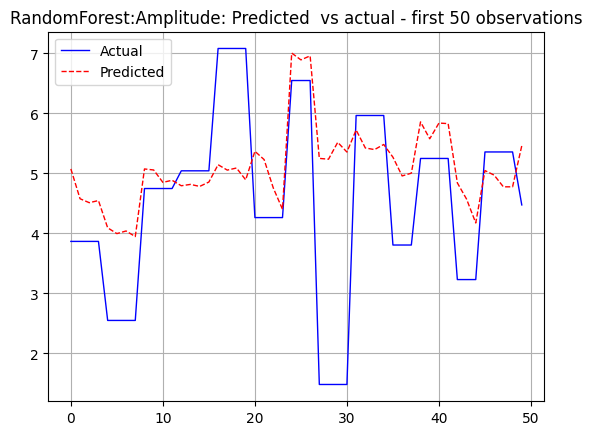

In [18]:
rf_regressor = RandomForestRegressor(criterion="squared_error",max_depth=3,random_state=1) # Try playing around with max_depth 3, 5, 8
rf_regressor.fit(X_train, yt_train)
yt_pred = rf_regressor.predict(X_test)
report_accuracy(yt_test, yt_pred, 'RandomForest:Time To Erupt')
rf_regressor.fit(X_train, ym_train)
ym_pred = rf_regressor.predict(X_test)
report_accuracy(ym_test, ym_pred, 'RandomForest:Amplitude')

GradientBoostTop5:Time To Erupt : r2=0.14459705152893, mean_squared_error=108409.16957794638


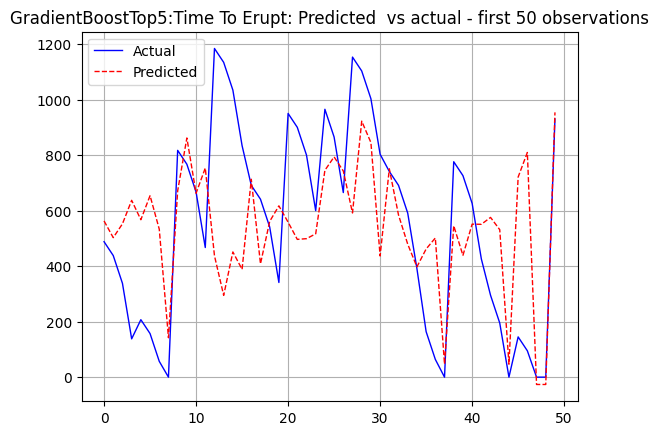

GradientBoostTop5:Amplitude : r2=0.2286304653415494, mean_squared_error=108409.16957794638


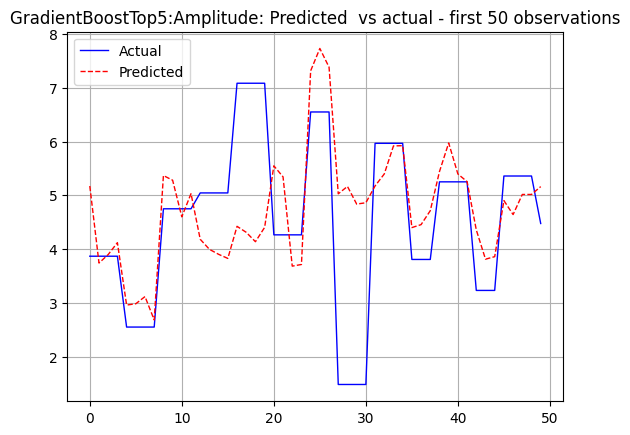

In [19]:
# Try only the top 5 Features to see if it makes a difference to R2 and mean squared error.
feature_indices_importance = rf_regressor.feature_importances_
feature_names = rf_regressor.feature_names_in_
remove_features = []
for i,x in enumerate(np.argsort(feature_indices_importance)[::-1][6:]):
  remove_features.append(feature_names[x])


X_train_pruned = X_train.drop(remove_features, axis=1)
X_test_pruned = X_test.drop(remove_features, axis=1)
# Try Boosting with Less number of Features
gb_regressor = HistGradientBoostingRegressor()
gb_regressor.fit(X_train_pruned, yt_train)
yt_pred = gb_regressor.predict(X_test_pruned)
report_accuracy(yt_test, yt_pred, 'GradientBoostTop5:Time To Erupt')
gb_regressor.fit(X_train, ym_train)
ym_pred = gb_regressor.predict(X_test)
report_accuracy(ym_test, ym_pred, 'GradientBoostTop5:Amplitude')

Let us go back to Boosting, but this time with AdaBoost and XGBoost

AdaBoost:Time To Erupt : r2=0.25893062331684435, mean_squared_error=93919.14754264413


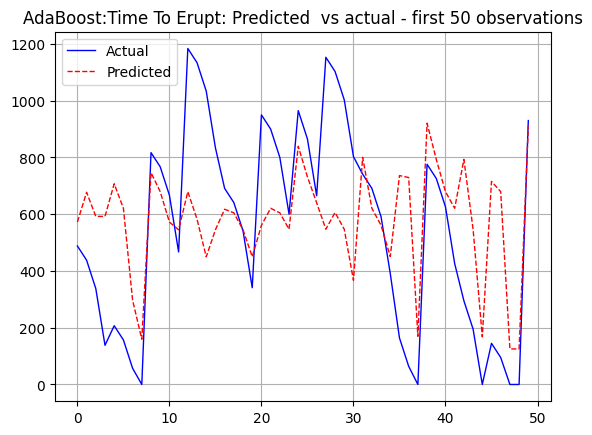

AdaBoost:Amplitude : r2=0.1726927780754629, mean_squared_error=93919.14754264413


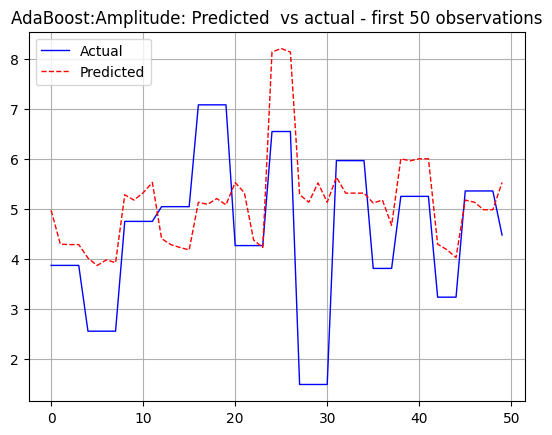

In [20]:
from sklearn.ensemble import AdaBoostRegressor
ada_regressor = AdaBoostRegressor()
ada_regressor.fit(X_train, yt_train)
yt_pred = ada_regressor.predict(X_test)
report_accuracy(yt_test, yt_pred, 'AdaBoost:Time To Erupt')
ada_regressor.fit(X_train, ym_train)
ym_pred = ada_regressor.predict(X_test)
report_accuracy(ym_test, ym_pred, 'AdaBoost:Amplitude')


XGBoost:Time To Erupt : r2=0.29701743216566345, mean_squared_error=89092.23020905945


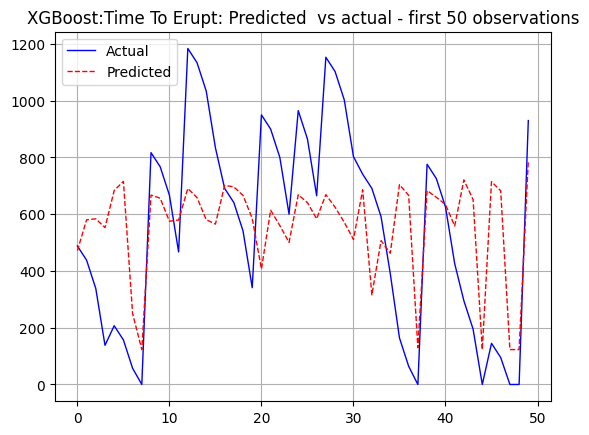

XGBoost:Amplitude : r2=0.11019283113217215, mean_squared_error=89092.23020905945


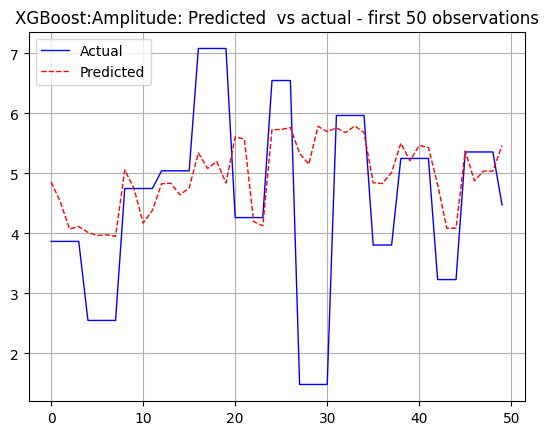

In [21]:
from xgboost import XGBRFRegressor
xg_regressor = XGBRFRegressor(reg_alpha=0.1, reg_lambda=10)
xg_regressor.fit(X_train, yt_train)
yt_pred = xg_regressor.predict(X_test)
report_accuracy(yt_test, yt_pred, 'XGBoost:Time To Erupt')
xg_regressor.fit(X_train, ym_train)
ym_pred = xg_regressor.predict(X_test)
report_accuracy(ym_test, ym_pred, 'XGBoost:Amplitude')

XGBoostTop5:Time To Erupt : r2=0.2930391118531922, mean_squared_error=89596.42113119848


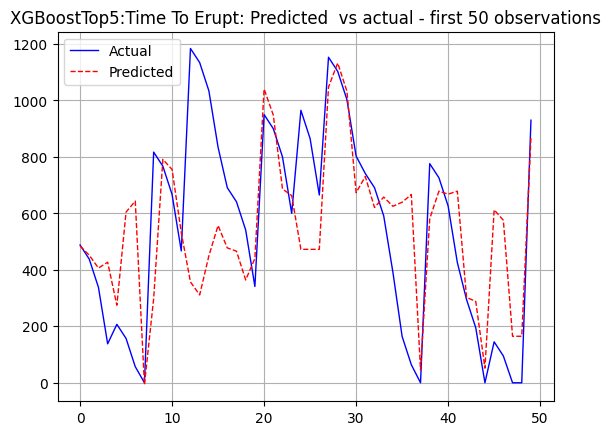

XGBoostTop5:Amplitude : r2=0.2286304653415494, mean_squared_error=89596.42113119848


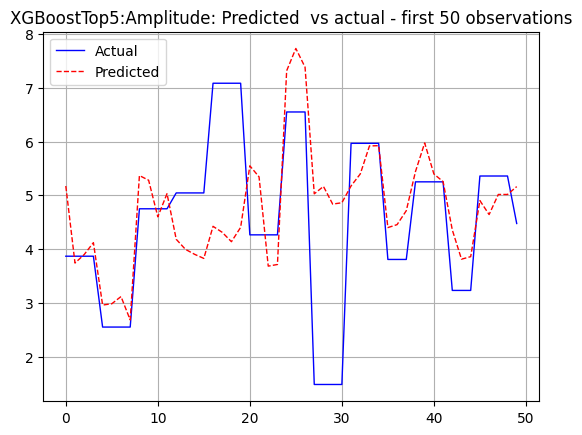

In [22]:
feature_indices_importance = xg_regressor.feature_importances_
feature_names = xg_regressor.feature_names_in_
remove_features = []
for i,x in enumerate(np.argsort(feature_indices_importance)[::-1][6:]):
  remove_features.append(feature_names[x])


X_train_pruned = X_train.drop(remove_features, axis=1)
X_test_pruned = X_test.drop(remove_features, axis=1)
# Try Boosting with Less number of Features
gb_regressor = HistGradientBoostingRegressor()
gb_regressor.fit(X_train_pruned, yt_train)
yt_pred = gb_regressor.predict(X_test_pruned)
report_accuracy(yt_test, yt_pred, 'XGBoostTop5:Time To Erupt')
gb_regressor.fit(X_train, ym_train)
ym_pred = gb_regressor.predict(X_test)
report_accuracy(ym_test, ym_pred, 'XGBoostTop5:Amplitude')

Let us summarize the findings in a dataframe

In [23]:
df = pd.DataFrame(dic_results)
df1 = df.filter(regex='Time To Erupt')
df1

,LinearRegressionTSFresh:Time To Erupt,DecisionTree:Time To Erupt,HistGradientBoost:Time To Erupt,RandomForest:Time To Erupt,GradientBoostTop5:Time To Erupt,AdaBoost:Time To Erupt,XGBoost:Time To Erupt,XGBoostTop5:Time To Erupt
r2,-1.380084e+03,-0.533612,0.155918,0.289989,0.144597,0.258931,0.297017,0.293039
mse,1.750311e+08,194361.770055,106974.453791,89982.999626,108409.169578,93919.147543,89092.230209,89596.421131


In [26]:
df2 = df.filter(regex='Amplitude')
df1.head()
df2.head()

,LinearRegression:Amplitude,DecisionTree:Amplitude,HistGradientBoost:Amplitude,RandomForest:Amplitude,GradientBoostTop5:Amplitude,AdaBoost:Amplitude,XGBoost:Amplitude
r2,-6.037372e+00,0.090257,0.450833,0.368303,0.450833,0.355036,0.333191
mse,1.870923e+06,160680.948708,111904.968563,91241.074783,124363.784369,104922.798876,92620.598298
